In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from scipy import stats

from pyuvdata import UVData, UVBeam
import linsolve
import hera_cal as hc
from scipy import signal

import hera_pspec as hp

from collections import OrderedDict as odict
from hera_cal.abscal import fill_dict_nans
plt.rcParams.update({'font.size': 14})
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)

/home/ntsikelelo/miniconda3/envs/hera37/lib/python3.7/site-packages/hera_sim/visibilities/__init__.py:22: UserWarning: HealVis failed to import.
  warnings.warn("HealVis failed to import.")
/home/ntsikelelo/miniconda3/envs/hera37/lib/python3.7/site-packages/hera_sim/visibilities/__init__.py:27: UserWarning: PRISim failed to import.
  warnings.warn("PRISim failed to import.")
/home/ntsikelelo/miniconda3/envs/hera37/lib/python3.7/site-packages/hera_sim/visibilities/__init__.py:33: UserWarning: VisGPU failed to import.
  warnings.warn("VisGPU failed to import.")
/home/ntsikelelo/miniconda3/envs/hera37/lib/python3.7/site-packages/hera_sim/__init__.py:36: FutureWarning: 
In the next major release, all HERA-specific variables will be removed from the codebase. The following variables will need to be accessed through new class-like structures to be introduced in the next major release: 

noise.HERA_Tsky_mdl
noise.HERA_BEAM_POLY
sigchain.HERA_NRAO_BANDPASS
rfi.HERA_RFI_STATIONS

Additionally, 

In [2]:
path='/home/ntsikelelo/non_redundancy_sim/'

## Load metadata 

In [3]:

# load the metadata
hd = hc.io.HERAData("/net/sinatra/vault-ike/ntsikelelo/Simulated_data_files/UVH5_files/Corrected_redundant_array_Model_zeroth_order_visibilities_2h_low_baseline_selected.uvh5")
freqs = hd.freq_array[0]
delays=np.fft.fftshift(np.fft.fftfreq(len(freqs),np.abs(freqs[1]-freqs[0])))*1e9

hd.read()
antpos, ants = hd.get_ENU_antpos()
antpos_d = dict(zip(ants, antpos))
model, _, _ = hd.build_datacontainers() #sky model 

The uvw_array does not match the expected values given the antenna positions. The largest discrepancy is 1.3999999994860333 meters. This is a fairly common situation but might indicate an error in the antenna positions, the uvws or the phasing.


In [4]:
# get redundant baseline groups
reds = hc.redcal.get_reds(antpos_d, pols=['ee'])
red_data=[]
for red_g in reds:
    bl_group=[]
    for bl in red_g:
        if bl in list(model.keys()):
            bl_group.append(bl)    
    if len(bl_group)>0:   
        red_data.append(bl_group)   

In [5]:
# # get redundant groups
antpos, ants = hd.get_ENU_antpos()
antpos_dict = dict(zip(ants, antpos))
# reds = hc.redcal.get_pos_reds(antpos_dict)

In [6]:
bl_lens, bl_groups = [], []
for red in red_data:
    # get the baseline length of this redundant group
    bl = red[0]
    bl_len = np.linalg.norm(antpos_dict[bl[1]] - antpos_dict[bl[0]])
    # check if this bl_len exists
    if np.isclose(bl_len, bl_lens, atol=1).any():
        bl_groups[-1].extend(red)
    else:
        bl_groups.append(red)
        bl_lens.append(bl_len)

## Wegde line parameters

In [7]:
b_14=14.6
c=3e8
b_28=2*b_14
tau_14=(b_14/c)*1e9
tau_28=(b_28/c)*1e9



m=(tau_28-tau_14)/(b_28-b_14)
c=tau_14-m*b_14
c_=-c
base_line=np.linspace(bl_lens[0], bl_lens[-1],32)
wedge_line=m*base_line+c
wedge_line_=-m*base_line+c_

In [8]:
tau_14

48.666666666666664

## residual for complete sky model

In [9]:
cal_wedge_fft_complete=np.load(path+"cal_wedge_fft_zeroth_vis_no_filter_low_2h.npy")
mdl_wedge_fft=np.load(path+"mdl_wedge_fft_zeroth_vis_no_filter_low_2h.npy")

In [10]:
cal_wedge_fft_complete.shape

(260, 59, 204, 1)

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


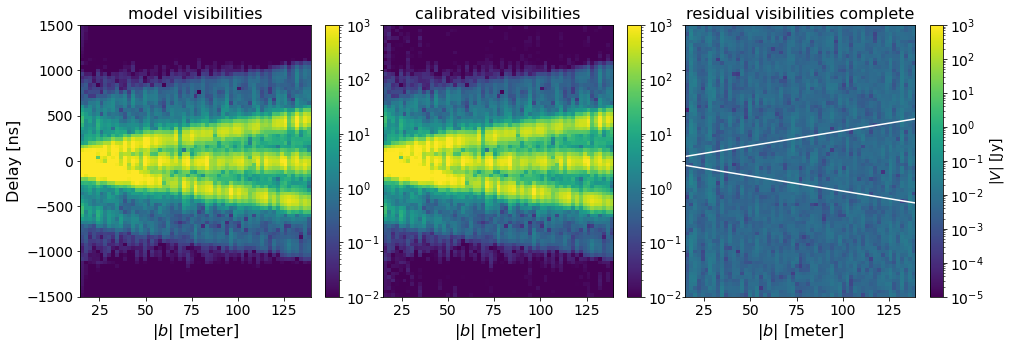

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.subplots_adjust(wspace=0.05)

ax = axes[0]
cax = ax.imshow(np.abs(mdl_wedge_fft[0,:, :,0].T), aspect='auto', norm=matplotlib.colors.LogNorm(),
                vmin=1e-2, vmax=1e3, extent=[bl_lens[0], bl_lens[-1], delays[-1], delays[0]])
ax.set_xlabel(r'$|b|$ [meter]', fontsize=16); ax.set_ylabel(r'Delay [ns]', fontsize=16)
ax.set_title("model visibilities", fontsize=16)
ax.set_ylim(-1500, 1500)
fig.colorbar(cax, ax=ax)


ax = axes[1]
cax = ax.imshow(np.abs(cal_wedge_fft_complete[0,:, :,0].T), aspect='auto', norm=matplotlib.colors.LogNorm(),
                vmin=1e-2, vmax=1e3, extent=[bl_lens[0], bl_lens[-1], delays[-1], delays[0]])
#fig.colorbar(cax, ax=ax)
ax.set_xlabel(r'$|b|$ [meter]', fontsize=16)
ax.set_title("calibrated visibilities", fontsize=16)
ax.set_yticklabels([])
ax.set_ylim(-1500, 1500)
fig.colorbar(cax, ax=ax)

ax = axes[2]
cax = ax.imshow(np.abs(mdl_wedge_fft - cal_wedge_fft_complete)[0,:, :,0].T, aspect='auto', norm=matplotlib.colors.LogNorm(),
                vmin=1e-5, vmax=1e3, extent=[bl_lens[0], bl_lens[-1], delays[-1], delays[0]])
ax.set_xlabel(r'$|b|$ [meter]', fontsize=16)
ax.set_title("residual visibilities complete", fontsize=16)
ax.set_ylim(-1500, 1500)
ax.set_yticklabels([])
fig.colorbar(cax, ax=ax, label=r"$|V|$ [Jy]")
plt.plot(base_line,wedge_line,'w')
plt.plot(base_line,wedge_line_,'w')


In [12]:
cal_wedge_fft_complete_non_redundant=np.load(path+"cal_wedge_fft_first_order_vis_no_filter_low_2h.npy")



Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


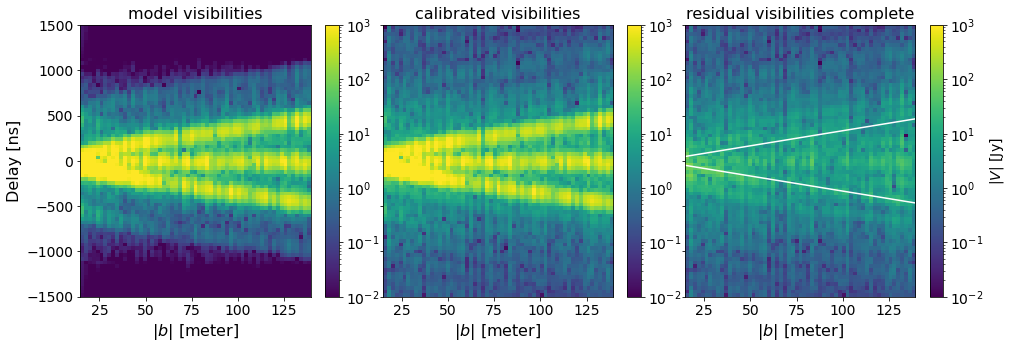

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.subplots_adjust(wspace=0.05)

ax = axes[0]
cax = ax.imshow(np.abs(mdl_wedge_fft[0,:, :,0].T), aspect='auto', norm=matplotlib.colors.LogNorm(),
                vmin=1e-2, vmax=1e3, extent=[bl_lens[0], bl_lens[-1], delays[-1], delays[0]])
ax.set_xlabel(r'$|b|$ [meter]', fontsize=16); ax.set_ylabel(r'Delay [ns]', fontsize=16)
ax.set_title("model visibilities", fontsize=16)
ax.set_ylim(-1500, 1500)
fig.colorbar(cax, ax=ax)


ax = axes[1]
cax = ax.imshow(np.abs(cal_wedge_fft_complete_non_redundant[0,:, :,0].T), aspect='auto', norm=matplotlib.colors.LogNorm(),
                vmin=1e-2, vmax=1e3, extent=[bl_lens[0], bl_lens[-1], delays[-1], delays[0]])
#fig.colorbar(cax, ax=ax)
ax.set_xlabel(r'$|b|$ [meter]', fontsize=16)
ax.set_title("calibrated visibilities", fontsize=16)
ax.set_yticklabels([])
ax.set_ylim(-1500, 1500)
fig.colorbar(cax, ax=ax)

ax = axes[2]
cax = ax.imshow(np.abs(mdl_wedge_fft - cal_wedge_fft_complete_non_redundant)[0,:, :,0].T, aspect='auto', norm=matplotlib.colors.LogNorm(),
                vmin=1e-2, vmax=1e3, extent=[bl_lens[0], bl_lens[-1], delays[-1], delays[0]])
ax.set_xlabel(r'$|b|$ [meter]', fontsize=16)
ax.set_title("residual visibilities complete", fontsize=16)
ax.set_ylim(-1500, 1500)
ax.set_yticklabels([])
fig.colorbar(cax, ax=ax, label=r"$|V|$ [Jy]")
plt.plot(base_line,wedge_line,'w')
plt.plot(base_line,wedge_line_,'w')

## residual filtered 25 mHz

In [14]:
cal_wedge_fft_complete_non_redundant_25=np.load(path+"cal_wedge_fft_first_order_vis_dpss_25_low_2h.npy")



Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


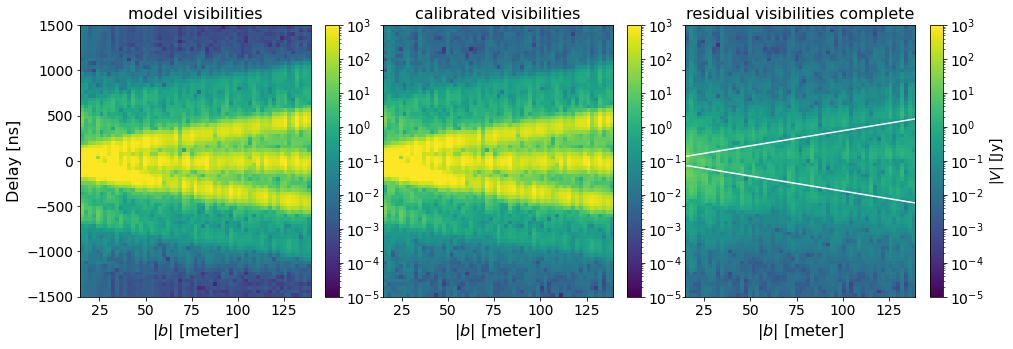

In [15]:

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.subplots_adjust(wspace=0.05)

ax = axes[0]
cax = ax.imshow(np.abs(mdl_wedge_fft[0,:, :,0].T), aspect='auto', norm=matplotlib.colors.LogNorm(),
                vmin=1e-5, vmax=1e3, extent=[bl_lens[0], bl_lens[-1], delays[-1], delays[0]])
ax.set_xlabel(r'$|b|$ [meter]', fontsize=16); ax.set_ylabel(r'Delay [ns]', fontsize=16)
ax.set_title("model visibilities", fontsize=16)
ax.set_ylim(-1500, 1500)
fig.colorbar(cax, ax=ax)


ax = axes[1]
cax = ax.imshow(np.abs(cal_wedge_fft_complete_non_redundant_25[0,:, :,0].T), aspect='auto', norm=matplotlib.colors.LogNorm(),
                vmin=1e-5, vmax=1e3, extent=[bl_lens[0], bl_lens[-1], delays[-1], delays[0]])
#fig.colorbar(cax, ax=ax)
ax.set_xlabel(r'$|b|$ [meter]', fontsize=16)
ax.set_title("calibrated visibilities", fontsize=16)
ax.set_yticklabels([])
ax.set_ylim(-1500, 1500)
fig.colorbar(cax, ax=ax)

ax = axes[2]
cax = ax.imshow(np.abs(mdl_wedge_fft - cal_wedge_fft_complete_non_redundant_25)[0,:, :,0].T, aspect='auto', norm=matplotlib.colors.LogNorm(),
                vmin=1e-5, vmax=1e3, extent=[bl_lens[0], bl_lens[-1], delays[-1], delays[0]])
ax.set_xlabel(r'$|b|$ [meter]', fontsize=16)
ax.set_title("residual visibilities complete", fontsize=16)
ax.set_ylim(-1500, 1500)
ax.set_yticklabels([])
fig.colorbar(cax, ax=ax, label=r"$|V|$ [Jy]")
plt.plot(base_line,wedge_line,'w')
plt.plot(base_line,wedge_line_,'w')

## Residual 

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


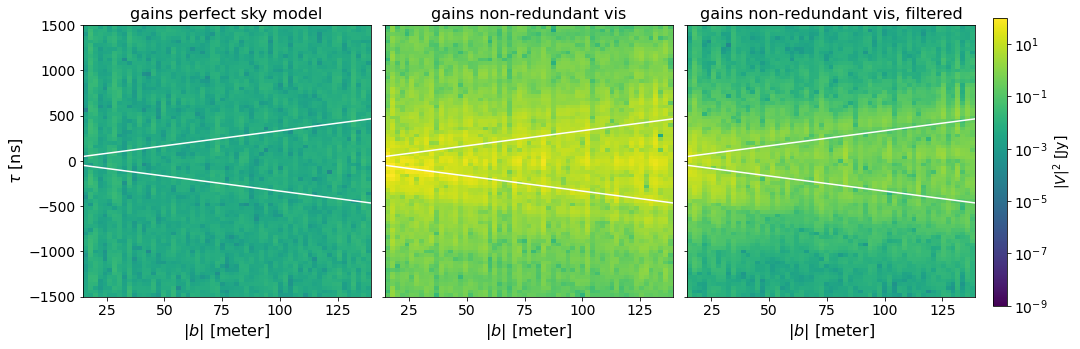

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.subplots_adjust(wspace=0.05)

ax = axes[0]
cax = ax.imshow(np.abs(mdl_wedge_fft - cal_wedge_fft_complete)[0,:, :,0].T, aspect='auto', norm=matplotlib.colors.LogNorm(),
                vmin=1e-9, vmax=1e2, extent=[bl_lens[0], bl_lens[-1], delays[-1], delays[0]])
#cbar = fig.colorbar(cax, ax=ax)
#cbar.ax.tick_params(labelsize=12)
ax.set_xlabel(r'$|b|$ [meter]', fontsize=16); ax.set_ylabel(r'$\tau$ [ns]', fontsize=16)
ax.set_title("gains perfect sky model", fontsize=16)
ax.set_ylim(-1500, 1500)
ax.plot(base_line,wedge_line,'w')
ax.plot(base_line,wedge_line_,'w')

ax = axes[1]
cax = ax.imshow(np.abs(mdl_wedge_fft - cal_wedge_fft_complete_non_redundant)[0,:, :,0].T, aspect='auto', norm=matplotlib.colors.LogNorm(),
                vmin=1e-9, vmax=1e2, extent=[bl_lens[0], bl_lens[-1], delays[-1], delays[0]])
#fig.colorbar(cax, ax=ax)
ax.set_xlabel(r'$|b|$ [meter]', fontsize=16)
ax.set_title("gains non-redundant vis", fontsize=16)
ax.set_yticklabels([])
ax.set_ylim(-1500, 1500)
ax.plot(base_line,wedge_line,'w')
ax.plot(base_line,wedge_line_,'w')

ax = axes[2]
cax = ax.imshow(np.abs(mdl_wedge_fft - cal_wedge_fft_complete_non_redundant_25)[0,:, :,0].T, aspect='auto', norm=matplotlib.colors.LogNorm(),
                vmin=1e-9, vmax=1e2, extent=[bl_lens[0], bl_lens[-1], delays[-1], delays[0]])
ax.set_xlabel(r'$|b|$ [meter]', fontsize=16)
ax.set_title("gains non-redundant vis, filtered", fontsize=16)
ax.set_ylim(-1500, 1500)
ax.plot(base_line,wedge_line,'w')
ax.plot(base_line,wedge_line_,'w')
ax.set_yticklabels([])
cbax = fig.add_axes([0.83, 0.1, 0.1, 0.8])
cbax.axis('off')
cbar = fig.colorbar(cax, ax=cbax, label=r"$|V|^2$ [Jy]");

## Average over time

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


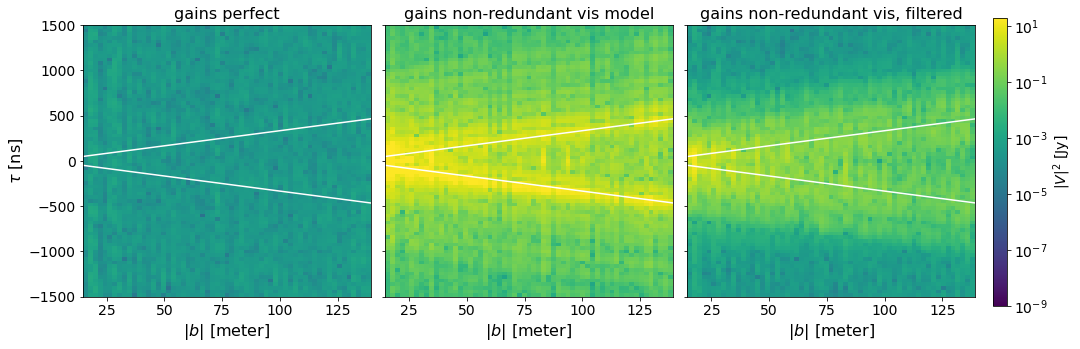

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.subplots_adjust(wspace=0.05)

ax = axes[0]
cax = ax.imshow(np.abs(np.mean((mdl_wedge_fft - cal_wedge_fft_complete)[:,:, :,0],axis=0)).T, aspect='auto', norm=matplotlib.colors.LogNorm(),
                vmin=1e-9, vmax=20, extent=[bl_lens[0], bl_lens[-1], delays[-1], delays[0]])
#cbar = fig.colorbar(cax, ax=ax)
#cbar.ax.tick_params(labelsize=12)
ax.set_xlabel(r'$|b|$ [meter]', fontsize=16); ax.set_ylabel(r'$\tau$ [ns]', fontsize=16)
ax.set_title("gains perfect", fontsize=16)
ax.set_ylim(-1500, 1500)
ax.plot(base_line,wedge_line,'w')
ax.plot(base_line,wedge_line_,'w')

ax = axes[1]
cax = ax.imshow(np.abs(np.mean((mdl_wedge_fft - cal_wedge_fft_complete_non_redundant)[:,:, :,0],axis=0)).T, aspect='auto', norm=matplotlib.colors.LogNorm(),
                vmin=1e-9, vmax=20, extent=[bl_lens[0], bl_lens[-1], delays[-1], delays[0]])
#fig.colorbar(cax, ax=ax)
ax.set_xlabel(r'$|b|$ [meter]', fontsize=16)
ax.set_title("gains non-redundant vis model", fontsize=16)
ax.set_yticklabels([])
ax.set_ylim(-1500, 1500)
ax.plot(base_line,wedge_line,'w')
ax.plot(base_line,wedge_line_,'w')

ax = axes[2]
cax = ax.imshow(np.abs(np.mean((mdl_wedge_fft - cal_wedge_fft_complete_non_redundant_25)[:,:, :,0], axis=0)).T, aspect='auto', norm=matplotlib.colors.LogNorm(),
                vmin=1e-9, vmax=20, extent=[bl_lens[0], bl_lens[-1], delays[-1], delays[0]])
ax.set_xlabel(r'$|b|$ [meter]', fontsize=16)
ax.set_title("gains non-redundant vis, filtered", fontsize=16)
ax.set_ylim(-1500, 1500)
ax.plot(base_line,wedge_line,'w')
ax.plot(base_line,wedge_line_,'w')
ax.set_yticklabels([])
cbax = fig.add_axes([0.83, 0.1, 0.1, 0.8])
cbax.axis('off')
cbar = fig.colorbar(cax, ax=cbax, label=r"$|V|^2$ [Jy]");

## All filters 

In [18]:
# cal_wedge_fft_complete_non_redundant_40=np.load(path+"cal_wedge_fft_first_order_vis_dpss_40_low_2h.npy")
# cal_wedge_fft_complete_non_redundant_60=np.load(path+"cal_wedge_fft_first_order_vis_dpss_60_low_2h.npy")
cal_wedge_fft_complete_non_redundant_Gaussian=np.load(path+"cal_wedge_fft_first_order_vis_Gaussian_low_2h.npy")

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


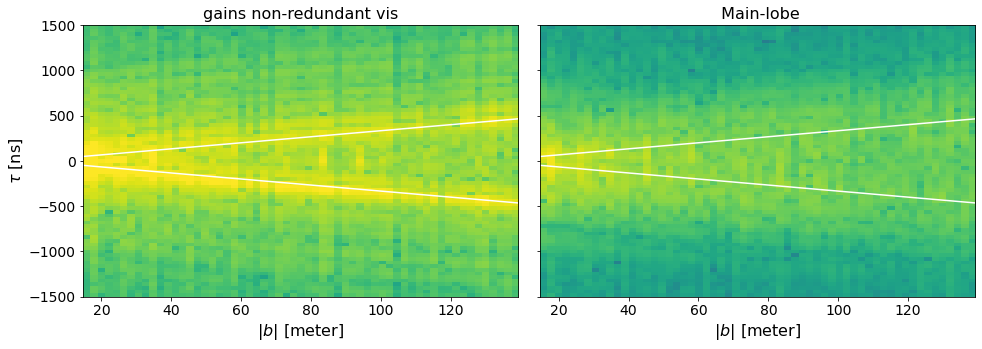

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
fig.subplots_adjust(wspace=0.05)


ax = axes[0]
cax = ax.imshow(np.abs(np.mean((mdl_wedge_fft - cal_wedge_fft_complete_non_redundant)[:,:, :,0],axis=0)).T, aspect='auto', norm=matplotlib.colors.LogNorm(),
                vmin=1e-9, vmax=20, extent=[bl_lens[0], bl_lens[-1], delays[-1], delays[0]])
#cbar = fig.colorbar(cax, ax=ax)
#cbar.ax.tick_params(labelsize=12)
ax.set_xlabel(r'$|b|$ [meter]', fontsize=16); ax.set_ylabel(r'$\tau$ [ns]', fontsize=16)
ax.set_title("gains non-redundant vis", fontsize=16)
ax.set_ylim(-1500, 1500)
ax.plot(base_line,wedge_line,'w')
ax.plot(base_line,wedge_line_,'w')

# ax = axes[1]
# cax = ax.imshow(np.abs(np.mean((mdl_wedge_fft - cal_wedge_fft_complete_non_redundant_25)[:,:, :,0],axis=0)).T, aspect='auto', norm=matplotlib.colors.LogNorm(),
#                 vmin=1e-9, vmax=20, extent=[bl_lens[0], bl_lens[-1], delays[-1], delays[0]])
# #cbar = fig.colorbar(cax, ax=ax)
# #cbar.ax.tick_params(labelsize=12)
# ax.set_xlabel(r'$|b|$ [meter]', fontsize=16)
# ax.set_title("filtered 25", fontsize=16)
# ax.set_yticklabels([])
# ax.set_ylim(-1500, 1500)
# ax.plot(base_line,wedge_line,'w')
# ax.plot(base_line,wedge_line_,'w')

ax = axes[1]
cax = ax.imshow(np.abs(np.mean((mdl_wedge_fft - cal_wedge_fft_complete_non_redundant_Gaussian)[:,:, :,0],axis=0)).T, aspect='auto', norm=matplotlib.colors.LogNorm(),
                vmin=1e-9, vmax=20, extent=[bl_lens[0], bl_lens[-1], delays[-1], delays[0]])
#fig.colorbar(cax, ax=ax)
ax.set_xlabel(r'$|b|$ [meter]', fontsize=16)
ax.set_title(" Main-lobe", fontsize=16)
ax.set_yticklabels([])
ax.set_ylim(-1500, 1500)
ax.plot(base_line,wedge_line,'w')
ax.plot(base_line,wedge_line_,'w')

# ax = axes[3]
# cax = ax.imshow(np.abs(np.mean((mdl_wedge_fft - cal_wedge_fft_complete_non_redundant_60)[:,:, :,0], axis=0)).T, aspect='auto', norm=matplotlib.colors.LogNorm(),
#                 vmin=1e-9, vmax=20, extent=[bl_lens[0], bl_lens[-1], delays[-1], delays[0]])
# ax.set_xlabel(r'$|b|$ [meter]', fontsize=16)
# ax.set_title(" filtered 60", fontsize=16)
# ax.set_ylim(-1500, 1500)
# ax.plot(base_line,wedge_line,'w')
# ax.plot(base_line,wedge_line_,'w')
# ax.set_yticklabels([])
# cbax = fig.add_axes([0.83, 0.1, 0.1, 0.8])
# cbax.axis('off')
# cbar = fig.colorbar(cax, ax=cbax, label=r"$|V|^2$ [Jy]");

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


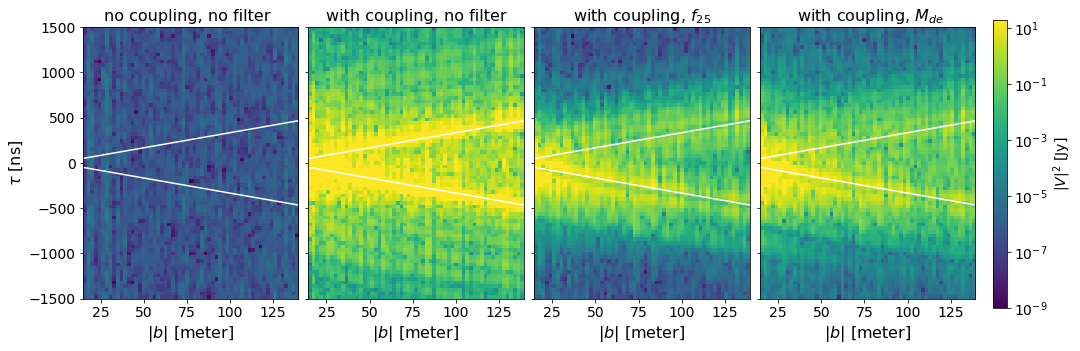

In [22]:
fig, axes = plt.subplots(1, 4, figsize=(16, 5))
fig.subplots_adjust(wspace=0.05)

ax = axes[0]
cax = ax.imshow(np.abs(np.mean((mdl_wedge_fft - cal_wedge_fft_complete)[0:58,:, :,0], axis=0)).T**2, aspect='auto', norm=matplotlib.colors.LogNorm(),
                vmin=1e-9, vmax=20, extent=[bl_lens[0], bl_lens[-1], delays[-1], delays[0]])
ax.set_xlabel(r'$|b|$ [meter]', fontsize=16); ax.set_ylabel(r'$\tau$ [ns]', fontsize=16)
ax.set_title("no coupling, no filter ", fontsize=16)
ax.set_ylim(-1500, 1500)
ax.plot(base_line,wedge_line,'w')
ax.plot(base_line,wedge_line_,'w')


ax = axes[1]
cax = ax.imshow(np.abs(np.mean((mdl_wedge_fft - cal_wedge_fft_complete_non_redundant)[0:58,:, :,0],axis=0)).T**2, aspect='auto', norm=matplotlib.colors.LogNorm(),
                vmin=1e-9, vmax=20, extent=[bl_lens[0], bl_lens[-1], delays[-1], delays[0]])
#cbar = fig.colorbar(cax, ax=ax)
#cbar.ax.tick_params(labelsize=12)
ax.set_xlabel(r'$|b|$ [meter]', fontsize=16)
ax.set_title("with coupling, no filter", fontsize=16)
ax.set_ylim(-1500, 1500)
ax.plot(base_line,wedge_line,'w')
ax.plot(base_line,wedge_line_,'w')
ax.set_yticklabels([])

ax = axes[2]
cax = ax.imshow(np.abs(np.mean((mdl_wedge_fft - cal_wedge_fft_complete_non_redundant_25)[0:58,:, :,0],axis=0)).T**2, aspect='auto', norm=matplotlib.colors.LogNorm(),
                vmin=1e-9, vmax=20, extent=[bl_lens[0], bl_lens[-1], delays[-1], delays[0]])
#cbar = fig.colorbar(cax, ax=ax)
#cbar.ax.tick_params(labelsize=12)
ax.set_xlabel(r'$|b|$ [meter]', fontsize=16)
ax.set_title("with coupling, $f_{25}$", fontsize=16)
ax.set_yticklabels([])
ax.set_ylim(-1500, 1500)
ax.plot(base_line,wedge_line,'w')
ax.plot(base_line,wedge_line_,'w')

ax = axes[3]
cax = ax.imshow(np.abs(np.mean((mdl_wedge_fft - cal_wedge_fft_complete_non_redundant_Gaussian)[0:58,:, :,0],axis=0)).T**2, aspect='auto', norm=matplotlib.colors.LogNorm(),
                vmin=1e-9, vmax=20, extent=[bl_lens[0], bl_lens[-1], delays[-1], delays[0]])
#fig.colorbar(cax, ax=ax)
ax.set_xlabel(r'$|b|$ [meter]', fontsize=16);  
ax.set_title(" with coupling, $M_{de}$", fontsize=16)
ax.set_yticklabels([])
ax.set_ylim(-1500, 1500)
ax.plot(base_line,wedge_line,'w')
ax.plot(base_line,wedge_line_,'w')
ax.set_yticklabels([])
cbax = fig.add_axes([0.83, 0.1, 0.1, 0.8])
cbax.axis('off')
cbar = fig.colorbar(cax, ax=cbax, label=r"$|V|^2$ [Jy]");


## residuals sqaured 

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


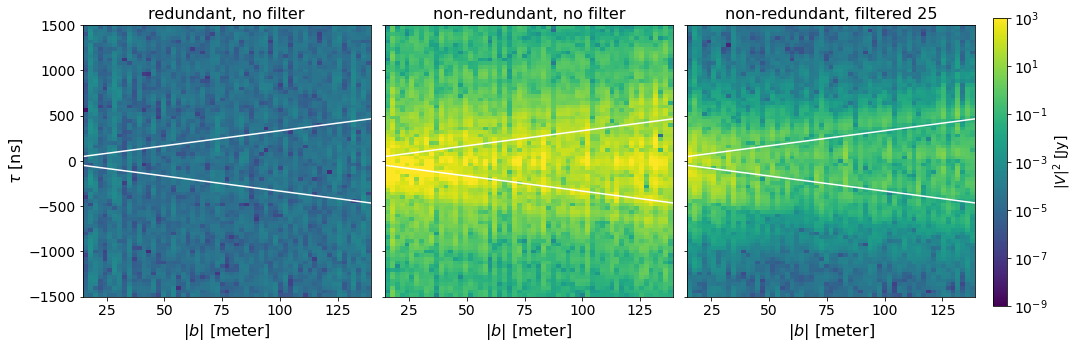

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.subplots_adjust(wspace=0.05)

ax = axes[0]
cax = ax.imshow(np.abs(mdl_wedge_fft - cal_wedge_fft_complete)[0,:, :,0].T**2, aspect='auto', norm=matplotlib.colors.LogNorm(),
                vmin=1e-9, vmax=1e3, extent=[bl_lens[0], bl_lens[-1], delays[-1], delays[0]])
#cbar = fig.colorbar(cax, ax=ax)
#cbar.ax.tick_params(labelsize=12)
ax.set_xlabel(r'$|b|$ [meter]', fontsize=16); ax.set_ylabel(r'$\tau$ [ns]', fontsize=16)
ax.set_title("redundant, no filter", fontsize=16)
ax.set_ylim(-1500, 1500)
ax.plot(base_line,wedge_line,'w')
ax.plot(base_line,wedge_line_,'w')
ax = axes[1]
cax = ax.imshow(np.abs(mdl_wedge_fft - cal_wedge_fft_complete_non_redundant)[0,:, :,0].T**2, aspect='auto', norm=matplotlib.colors.LogNorm(),
                vmin=1e-9, vmax=1e3, extent=[bl_lens[0], bl_lens[-1], delays[-1], delays[0]])
#fig.colorbar(cax, ax=ax)
ax.set_xlabel(r'$|b|$ [meter]', fontsize=16)
ax.set_title("non-redundant, no filter", fontsize=16)
ax.set_yticklabels([])
ax.set_ylim(-1500, 1500)
ax.plot(base_line,wedge_line,'w')
ax.plot(base_line,wedge_line_,'w')

ax = axes[2]
cax = ax.imshow(np.abs(mdl_wedge_fft - cal_wedge_fft_complete_non_redundant_25)[0,:, :,0].T**2, aspect='auto', norm=matplotlib.colors.LogNorm(),
                vmin=1e-9, vmax=1e3, extent=[bl_lens[0], bl_lens[-1], delays[-1], delays[0]])
ax.set_xlabel(r'$|b|$ [meter]', fontsize=16)
ax.set_title("non-redundant, filtered 25", fontsize=16)
ax.set_ylim(-1500, 1500)
ax.plot(base_line,wedge_line,'w')
ax.plot(base_line,wedge_line_,'w')
ax.set_yticklabels([])
cbax = fig.add_axes([0.83, 0.1, 0.1, 0.8])
cbax.axis('off')
cbar = fig.colorbar(cax, ax=cbax, label=r"$|V|^2$ [Jy]");


## Power spectrum for redundant baselines 

In [28]:
def JytomK(Jy, f0=163e6):
    """Convert Jansky to mK

    Args:
        Jy (float): brightness in Jy
        f0 (float): frequency in Hz

    Returns:
        float: brightness temperature in mK
    """

    # wavelength in m
    c=3.0e8
    lam = c / f0

    # flux density in W/m^2/Hz
    S = Jy * 1e-26
    kb=1.38064852e-23
    # temperature in K
    T = S * lam ** 2 / (2 * kb)

    # rettourn temperature in mK
    return T * 1e3

def power_spectrum(V, baseline, f1, df, delays):
    window = signal.blackmanharris(delays.shape[0])
    comso=hp.conversions.Cosmo_Conversions(Om_l=0.7,H0=70,Om_c=0.3)
    c=3e8
   
    f0=1420.0e6
    lambda_0=c/f0
    lambda_1=c/f1

    z=(lambda_1-lambda_0)/lambda_0
    factor=comso.bl_to_kperp(z=z)
    theta=(lambda_1/baseline)
    Dc=comso.dRperp_dtheta(z)*theta
    Beff=np.sum(window*df)
    Delta_D=comso.dRpara_df(z)*Beff
    k_par=comso.tau_to_kpara(z=z)*delays*1e-9
    k_per=factor*baseline
    theta_d=np.rad2deg(theta)
    Ae=theta_d**2
    

    steradian=(180.0/np.pi)**2 #degrees per steradian
    Omega= Ae/steradian
    V_mk=JytomK(Jy=V,f0=f1)
    constant=((Dc**2*Delta_D)/(Beff))*(1/(Omega*Beff))
    P=V_mk**2*constant*df**2
    
    print(" at redshift "+str(z))
    return k_par,np.array(P)


In [29]:
path="/home/ntsikelelo/non_redundancy_sim/"
bl=np.linspace(bl_lens[0],bl_lens[-1],cal_wedge_fft_complete_non_redundant_25.shape[1])
baseline=14
bls_res=np.abs(bl-baseline)
n=0
N=58

bls_g=np.where(bls_res==np.min(bls_res))[0][0]
freqs=model.freqs
df=np.abs(freqs[1]-freqs[0])
f1=freqs[int(len(freqs)/2)]
res_25=np.mean((mdl_wedge_fft-cal_wedge_fft_complete_non_redundant_25)[n:N,bls_g,:,0],axis=0)
# res_40=np.mean(np.mean((mdl_wedge_fft-cal_wedge_fft_complete_non_redundant_40)[0,:,:,:],axis=0),axis=1)
# res_60=np.mean(np.mean((mdl_wedge_fft-cal_wedge_fft_complete_non_redundant_60)[0,:,:,:],axis=0),axis=1)
res_G=np.mean((mdl_wedge_fft-cal_wedge_fft_complete_non_redundant_Gaussian)[n:N,bls_g,:,0],axis=0)
res=np.mean((mdl_wedge_fft-cal_wedge_fft_complete_non_redundant)[2:10,bls_g,:,0],axis=0)
res_red=np.mean((mdl_wedge_fft-cal_wedge_fft_complete)[n:N,bls_g,:,0],axis=0)





# k_par,P_40=power_spectrum(np.abs(res_40), baseline, f1, df, delays)
k_par,P=power_spectrum(np.abs(res), baseline, f1, df, delays)
k_par,P_red=power_spectrum(np.abs(res_red), baseline, f1, df, delays)
k_par,P_G=power_spectrum(np.abs(res_G), baseline, f1, df, delays)
# k_par,P_60=power_spectrum(np.abs(res_60), baseline, f1, df, delays)
k_par,P_25=power_spectrum(np.abs(res_25), baseline, f1, df, delays)

 at redshift 8.310767383691847
 at redshift 8.310767383691847
 at redshift 8.310767383691847
 at redshift 8.310767383691847


(-1.5, 1.5)

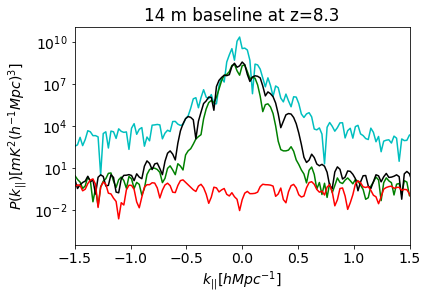

In [30]:
# plt.figure(figsize=(15,10))
plt.semilogy(k_par,P,'c',label="non-redundant, no filter")
# plt.semilogy(k_par,P_40,'g',label="non-redundant, 0.40 mHz")
# plt.semilogy(k_par,P_60,'c',label="non-redundant, 0.60 mHz")
plt.semilogy(k_par,P_25,'g',label="non-redundant, 0.25 mHz")
plt.semilogy(k_par,P_G,'k',label="non-redundant, main-lobe")
plt.semilogy(k_par,P_red,'r',label="redundant")
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P(k_{||})$[$mK^2 (h^{-1} Mpc)^3]$")
# plt.legend()
plt.title(str(int(bl[0]))+" m baseline at z=8.3")

plt.xlim([-1.5,1.5])

(0.0, 1.5)

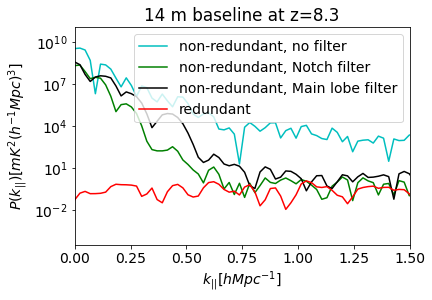

In [31]:
# plt.figure(figsize=(15,10))
plt.semilogy(k_par,P,'c',label="non-redundant, no filter")
plt.semilogy(k_par,P_25,'g',label="non-redundant, Notch filter")
plt.semilogy(k_par,P_G,'k',label="non-redundant, Main lobe filter")
plt.semilogy(k_par,P_red,'r',label="redundant")
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P(k_{||})$[$mK^2 (h^{-1} Mpc)^3]$")
plt.legend()
plt.title(str(int(bl[0]))+" m baseline at z=8.3")

plt.xlim([0,1.5])

## At two hours

In [27]:
path="/home/ntsikelelo/non_redundancy_sim/"
bl=np.linspace(bl_lens[0],bl_lens[-1],cal_wedge_fft_complete_non_redundant_25.shape[1])
baseline=14
bls_res=np.abs(bl-baseline)
n=118
N=n+10

bls_g=np.where(bls_res==np.min(bls_res))[0][0]
freqs=model.freqs
df=np.abs(freqs[1]-freqs[0])
f1=freqs[int(len(freqs)/2)]
res_25=np.mean((mdl_wedge_fft-cal_wedge_fft_complete_non_redundant_25)[n:N,bls_g,:,0],axis=0)
# res_40=np.mean(np.mean((mdl_wedge_fft-cal_wedge_fft_complete_non_redundant_40)[0,:,:,:],axis=0),axis=1)
# res_60=np.mean(np.mean((mdl_wedge_fft-cal_wedge_fft_complete_non_redundant_60)[0,:,:,:],axis=0),axis=1)
res_G=np.mean((mdl_wedge_fft-cal_wedge_fft_complete_non_redundant_Gaussian)[n:N,bls_g,:,0],axis=0)
res=np.mean((mdl_wedge_fft-cal_wedge_fft_complete_non_redundant)[2:10,bls_g,:,0],axis=0)
res_red=np.mean((mdl_wedge_fft-cal_wedge_fft_complete)[n:N,bls_g,:,0],axis=0)




# k_par,P_40=power_spectrum(np.abs(res_40), baseline, f1, df, delays)
k_par,P=power_spectrum(np.abs(res), baseline, f1, df, delays)
k_par,P_red=power_spectrum(np.abs(res_red), baseline, f1, df, delays)
k_par,P_G=power_spectrum(np.abs(res_G), baseline, f1, df, delays)
# k_par,P_60=power_spectrum(np.abs(res_60), baseline, f1, df, delays)
k_par,P_25=power_spectrum(np.abs(res_25), baseline, f1, df, delays)

 at redshift 8.310767383691847
 at redshift 8.310767383691847
 at redshift 8.310767383691847
 at redshift 8.310767383691847


(-1.5, 1.5)

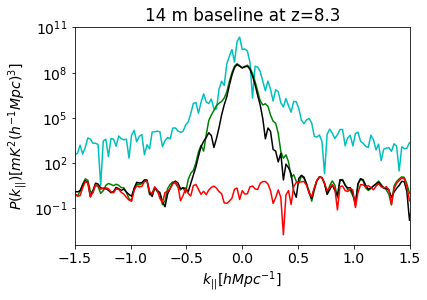

In [28]:
# plt.figure(figsize=(15,10))
plt.semilogy(k_par,P,'c',label="non-redundant, no filter")
# plt.semilogy(k_par,P_40,'g',label="non-redundant, 0.40 mHz")
# plt.semilogy(k_par,P_60,'c',label="non-redundant, 0.60 mHz")
plt.semilogy(k_par,P_25,'g',label="non-redundant, 0.25 mHz")
plt.semilogy(k_par,P_G,'k',label="non-redundant, main-lobe")
plt.semilogy(k_par,P_red,'r',label="redundant")
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P(k_{||})$[$mK^2 (h^{-1} Mpc)^3]$")
# plt.legend()
plt.title(str(int(bl[0]))+" m baseline at z=8.3")

plt.xlim([-1.5,1.5])

(0.0, 1.5)

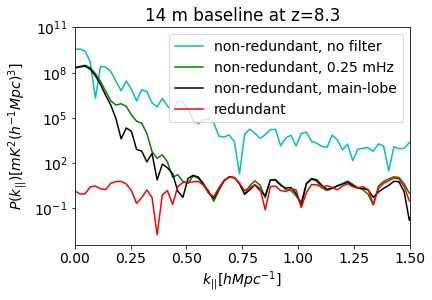

In [29]:
# plt.figure(figsize=(15,10))
plt.semilogy(k_par,P,'c',label="non-redundant, no filter")
plt.semilogy(k_par,P_25,'g',label="non-redundant, 0.25 mHz")
plt.semilogy(k_par,P_G,'k',label="non-redundant, main-lobe")
plt.semilogy(k_par,P_red,'r',label="redundant")
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P(k_{||})$[$mK^2 (h^{-1} Mpc)^3]$")
plt.legend()
plt.title(str(int(bl[0]))+" m baseline at z=8.3")

plt.xlim([0,1.5])

(0.0, 1.5)

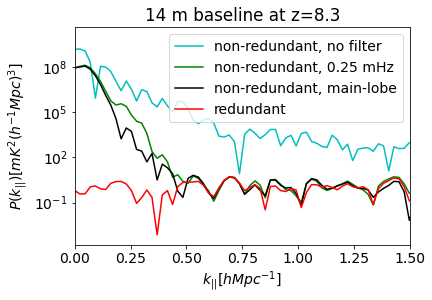

In [34]:
plt.semilogy(k_par,P/np.mean(P_red),'c',label="non-redundant, no filter")
plt.semilogy(k_par,P_25/np.mean(P_red),'g',label="non-redundant, 0.25 mHz")
plt.semilogy(k_par,P_G/np.mean(P_red),'k',label="non-redundant, main-lobe")
plt.semilogy(k_par,P_red/np.mean(P_red),'r',label="redundant")
plt.xlabel("$k_{||}[h Mpc^{-1}]$")
plt.ylabel("$P(k_{||})$[$mK^2 (h^{-1} Mpc)^3]$")
plt.legend()
plt.title(str(int(bl[0]))+" m baseline at z=8.3")

plt.xlim([0,1.5])